In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import robust_value_approx.relu_system as relu_system
import robust_value_approx.lyapunov as lyapunov
import robust_value_approx.pybullet_data as pybullet_data
import robust_value_approx.dynamics_learning as dynamics_learning
import robust_value_approx.encoders as encoders

import robust_value_approx.test.train_2d_lyapunov_utils as train_2d_lyapunov_utils

## Settings

In [3]:
# data
urdf = 'pendulum.urdf'
dtype = torch.float64
pybullet_x_lo = torch.tensor([-np.pi/2, -5.], dtype=dtype)
pybullet_x_up = torch.tensor([np.pi/2, 5.], dtype=dtype)
dt = .1
grayscale = True
# image_width = 28
# image_height = 28
image_width = 48
image_height = 48

# training
num_samples = 1000
validation_ratio = .01
batch_size = 30

dyn_learning_opt = dynamics_learning.DynamicsLearningOptions()
dyn_learning_opt.dynynamics_loss_weight = 10.
dyn_learning_opt.lyapunov_loss_at_samples_weight = 1.
dyn_learning_opt.lyapunov_loss_weight = 1.
dyn_learning_opt.equilibrium_loss_weight = 1.
dyn_learning_opt.V_lambda = 0.
dyn_learning_opt.V_eps = 0.01
        
# encoder-decoder
# encoder_class = encoders.LinearEncoder1
# decoder_class = encoders.LinearDecoder1
encoder_class = encoders.CNNEncoder1
decoder_class = encoders.CNNDecoder1
use_bce = True
use_variational = False
z_dim = 50
z_lo = -1. * torch.ones(z_dim, dtype=dtype)
z_up = 1. * torch.ones(z_dim, dtype=dtype)

# dynamics nn
dyn_nn_width = 10
dyn_nn_depth = 1

# lyapunov nn
lyap_nn_width = 10
lyap_nn_depth = 1

## Generating data

In [4]:
pbsg = pybullet_data.PybulletSampleGenerator(urdf, image_width=image_width, image_height=image_height, dtype=dtype)
x_data, x_next_data, X_data, X_next_data = pbsg.generate_dataset(pybullet_x_lo, pybullet_x_up, dt, num_samples, grayscale=grayscale)

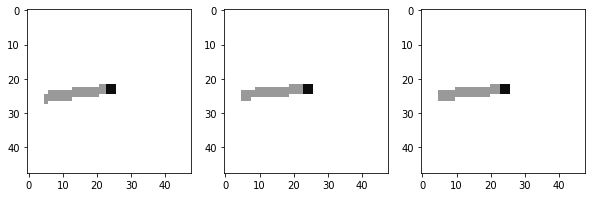

In [5]:
# plot some of the data
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data.show_sample(X_data[i,:], X_next_data[i,:])

## Learning in state space

In [ ]:
train_dataloader, validation_dataloader = dynamics_learning.get_dataloaders(x_data, x_next_data, batch_size, validation_ratio)

dyn_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, z_dim, dyn_nn_width, dyn_nn_depth)
lyap_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, 1, lyap_nn_width, lyap_nn_depth)

relu_sys = relu_system.AutonomousReLUSystem(dtype, z_lo, z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)

dyn_learner = dynamics_learning.StateSpaceDynamicsLearning(train_dataloader, validation_dataloader, relu_sys, lyap, dyn_learning_opt)

In [ ]:
dyn_learner.train(10, validate=True)

In [ ]:
x_traj = dyn_learner.rollout(x_data[np.random.choice(x_data.shape[0], 1)[0], :], 100)
plt.plot(x_traj)
plt.show()

## Learning in image space

In [6]:
train_dataloader, validation_dataloader = dynamics_learning.get_dataloaders(X_data, X_next_data, batch_size, validation_ratio)

dyn_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, z_dim, dyn_nn_width, dyn_nn_depth)
lyap_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, 1, lyap_nn_width, lyap_nn_depth)

relu_sys = relu_system.AutonomousReLUSystem(dtype, z_lo, z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)
encoder = encoder_class(z_dim, image_width, image_height, grayscale)
decoder = decoder_class(z_dim, image_width, image_height, grayscale)

dyn_learner = dynamics_learning.LatentSpaceDynamicsLearning(train_dataloader, validation_dataloader, relu_sys, lyap, dyn_learning_opt,
                                                            encoder, decoder, use_bce=use_bce, use_variational=use_variational)

In [23]:
# pre-training (encoder/decoder only)
dyn_learner.train_encoder(500, validate=True)

KeyboardInterrupt: 

In [ ]:
dyn_learner.train(10, validate=True)

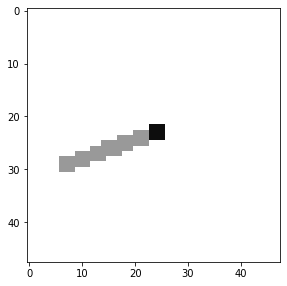

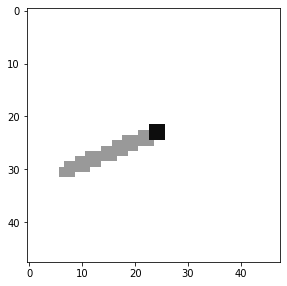

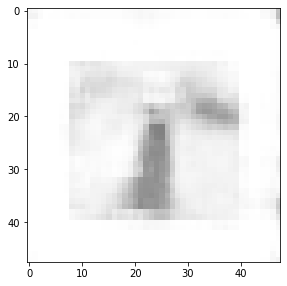

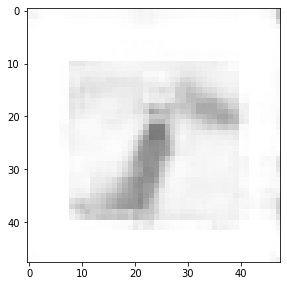

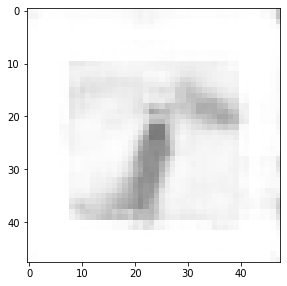

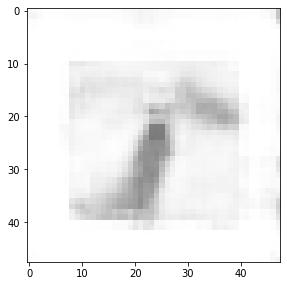

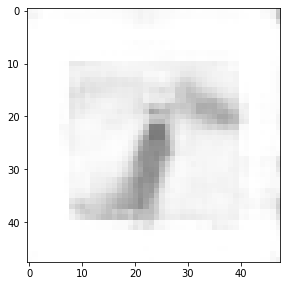

In [29]:
# plot a random rollout
x_traj = dyn_learner.rollout(X_data[np.random.choice(X_data.shape[0], 1)[0], :], 5)
for n in range(x_traj.shape[0]):
    pybullet_data.show_sample(x_traj[n, :])